In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/딥러닝

/content/drive/MyDrive/Colab Notebooks/딥러닝


In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
# 공개 데이터셋에서 학습 데이터를 내려받기
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# 공개 데이터셋에서 테스트 데이터를 내려받기
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:05<00:00, 4462254.64it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 282933.86it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5060938.20it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16065682.29it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
batch_size = 64

# 데이터로더 생성
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


### 모델 만들기

In [7]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻는다
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 모델 정의
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 모델 매개변수 최적화하기
- 모델을 학습하려면 손실 함수(loss function)와 옵티마이저(optimizer)가 필요

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

- 모델이 학습하고 있는지를 확인하기 위해 테스트 데이터셋으로 모델의 성능을 확인

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

- 학습 단계는 여러 번의 반복 단계 (에폭(epochs))를 거쳐서 수행된다. 각 에폭에서는 모델은 더 나은 예측을 하기 위해 매개 변수를 학습한다. 각 에폭마다 모델의 정확도(accuracy)와 손실(loss)를 출력한다. 에폭마다 정확도가 증가하고 손실이 감소하는 것을 보려고 한다.

In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311012  [   64/60000]
loss: 2.292843  [ 6464/60000]
loss: 2.273588  [12864/60000]
loss: 2.266989  [19264/60000]
loss: 2.259267  [25664/60000]
loss: 2.226296  [32064/60000]
loss: 2.234551  [38464/60000]
loss: 2.203188  [44864/60000]
loss: 2.193263  [51264/60000]
loss: 2.164821  [57664/60000]
Test Error: 
 Accuracy: 47.7%, Avg loss: 2.162859 

Epoch 2
-------------------------------
loss: 2.173961  [   64/60000]
loss: 2.157240  [ 6464/60000]
loss: 2.105342  [12864/60000]
loss: 2.124027  [19264/60000]
loss: 2.073591  [25664/60000]
loss: 2.016725  [32064/60000]
loss: 2.038803  [38464/60000]
loss: 1.969054  [44864/60000]
loss: 1.959781  [51264/60000]
loss: 1.890615  [57664/60000]
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.896804 

Epoch 3
-------------------------------
loss: 1.926895  [   64/60000]
loss: 1.886988  [ 6464/60000]
loss: 1.784910  [12864/60000]
loss: 1.829325  [19264/60000]
loss: 1.708404  [25664/60000]
loss: 1.667254  [32064/600

### 모델 저장하기
- 모델을 저장하는 일반적인 방법은 (모델의 매개변수들을 포함하여) 내부 상태 사전 (internal state dictionary)을 직렬화(serialize)하는 것이다.

In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### 모델 불러오기
- 모델을 불러오는 과정에는 모델 구조를 다시 만들고 상태 사전을 모델에 불러오는 과정이 포함된다.

In [14]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## 텐서(Tensor)
- 텐서(tensor)는 배열(array)이나 행렬(matrix)과 매우 유사한 특수한 자료구조이다. PyTorch에서는 텐서를 사용하여 모델의 입력(input)과 출력(output), 그리고 모델의 매개변수들을 부호화(encode)한다.

In [18]:
import torch
import numpy as np

### 텐서(tensor) 초기화

In [16]:
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)
print(data)

[[1, 2], [3, 4]]


**Numpy 배열로부터 생성하기**
- 텐서는 NumPy 배열로 생성할 수 있다. (그 반대도 가능)


In [19]:
np_array = np.array(data)  # type이 ndarray
x_np = torch.from_numpy(np_array)  # type이 tensor
print(type(x_np))

<class 'torch.Tensor'>


**다른 텐서로부터 생성하기:**
- 명시적으로 재정의(override)하지 않는다면, 인자로 주어진 텐서의 속성(모양(shape), 자료형(datatype))을 유지한다.

In [20]:
x_ones = torch.ones_like(x_data)  # 입력 텐서와 같은 형태의 1로 채워진 텐서 (x_data의 속성을 유지)
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float)  # 입력 텐서와 같은 형태의 랜덤 텐서 (X_data의 속성을 덮어씀)
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.8367, 0.4713],
        [0.8288, 0.0662]]) 



**무작위(random) 또는 상수(constant) 값을 사용하기:**
- shape 은 텐서의 차원(dimension)을 나타내는 튜플(tuple)로, 아래 함수들에서는 출력 텐서의 차원을 결정한다.

In [22]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.2266, 0.5631, 0.3599],
        [0.6330, 0.4161, 0.2584]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


#### 텐서의 속성(Attribute)
- 텐서의 속성은 텐서의 모양(shape), 자료형(datatype) 및 어느 장치에 저장되는지를 나타낸다.

In [23]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


#### 텐서의 연산(Operation)
- 전치(transporing), 인덱싱(indexing), 슬라이싱(slicing), 수학 계산, 선형 대수, 임의 샘플링(random sampling) 등, 100가지 이상의 텐서 연산들이 가능하다.
- 각 연산들은 (일반적으로 CPU보다 빠른) GPU에서 실행 가능하다. Colab을 사용한다면, Edit > Notebook Settings에서 GPU를 할당할 수 있다.
- 기본적으로는 텐서는 CPU에 생성된다. .to 메소드를 사용하면 (GPU의 가용성(Availability)을 확인한 뒤) GPU로 텐서를 명시적으로 이동할 수 있다. 장치들 간에 큰 텐서들을 복사하는 것은 시간과 메모리 측면에서 비용이 많이 든다. 그렇기 때문에 항상 GPU에서 CPU로 변환 후 복사하는 것이 유리하다.

In [24]:
# GPU가 존재하면 텐서를 이동한다
if torch.cuda.is_available():
    tensor = tensor.to("cuda")
print(tensor.dtype)

torch.float32


**Numpy식의 표준 인덱싱과 슬라이싱:**

In [25]:
tensor = torch.ones(4,4)
print('First row: ', tensor[0])
print('First column: ', tensor[:, 0])
print('Last column:', tensor[..., -1])
tensor[:,1] = 0
print(tensor)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**텐서 합치기**
- torch.cat을 사용하여 주어진 차원에 따라 일련의 텐서를 연결할 수 있다.

In [26]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [28]:
t2 = torch.cat([tensor, tensor, tensor], dim=0)
print(t2)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**산술 연산(Arithmetic operations)**

In [30]:
# 두 텐서 간의 행렬 곱(matrix multiplication)을 계산한다. y1, y2, y3은 모두 같은 값을 갖는다.
# ``tensor.T``는 텐서의 전치(transpose)를 반환한다.
y1 = tensor @ tensor.T   # M*N N*M => M * M
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(tensor)
torch.matmul(tensor, tensor.T, out=y3)

# 요소별 곱(element-wise product)을 계산한다. z1, z2, z3은 모두 같은 값을 갖는다.
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

**단일-요소(single-element) 텐서**
- 텐서의 모든 값을 하나로 집계(aggregate)하여 요소가 하나인 텐서의 경우, item()을 사용하여 Python 숫자 값으로 변환할 수 있다.

In [31]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


**바꿔치기(in-place) 연산**
- 연산 결과를 피연산자(operand)에 저장하는 연산을 바꿔치기 연산이라고 부르며, _ 접미사를 갖는다.
- 예를 들어, x.copy_(y)나 x.t_()는 x를 변경한다.

In [32]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


- 바꿔치기 연산은 메모리를 일부 절약하지만, 기록(history)이 즉시 삭제되어 도함수(derivative) 계산에 문제가 발생할 수 있다.
- 따라서, 사용을 권장하지 않음!

#### NumPy 변환(Bridge)
- CPU 상의 텐서와 NumPy 배열은 메모리 공간을 공유하기 때문에, 하나를 변경하면 다른 하나도 변경된다.

In [33]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


- 텐서의 변경 사항이 NumPy 배열에 반영된다.

In [34]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


#### NumPy 배열을 텐서로 변환하기

In [35]:
n = np.ones(5)
t = torch.from_numpy(n)

- MNIST
  - images
    - 0
      - one_000.png
      - one_001.png
    - 1
    - 2
    - 3
  - label

### 데이터셋 불러오기

### Dataset과 Dataloader

In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## 데이터셋을 순회하고 시각화하기
- Dataset에 리스트(list)처럼 직접 접근(index)할 수 있다 : training_data[index].matplotlib을 사용하여 학습 데이터의 일부를 시각화해보자.

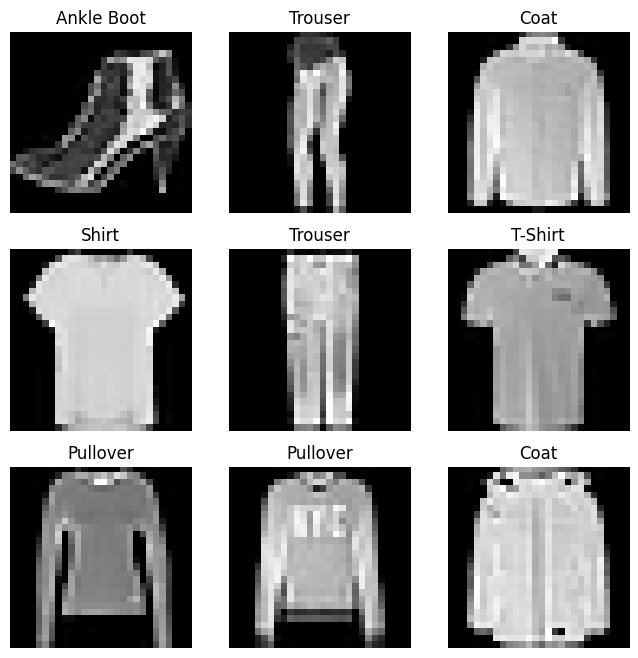

In [38]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 파일에서 사용자 정의 데이터셋 만들기
- 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

### `__init__`
- init 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행된다. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두가지 변형(transform)을 초기화한다.

### DataLoader로 학습용 데이터 준비하기